<a href="https://colab.research.google.com/github/ropatta/arquivo/blob/main/PSD_analise_ia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analise e IA

na raiz devem estar os seguintes arquivos:
 - curvas/
 - psd.py
 - psd_plot.py
 - config_parametros.py
 - metricas.csv




In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import ParameterGrid
import psd
import psd_plot as pp
import os
import importlib
import config_parametros as cfg
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D
importlib.reload(psd)
importlib.reload(pp)
importlib.reload(cfg)

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
plt.style.use('classic')
pd.options.mode.chained_assignment = None

         tempo  corrente
0     0.002977     -0.68
11    0.035993     -1.55
19    0.059976     -0.73
13    0.041998     -1.65
35    0.107985     -0.80
...        ...       ...
1929  5.789996     -1.30
1940  5.823055     -1.25
1938  5.817025     -1.30
1950  5.852992     -1.27
1951  5.856002     -1.30

[302 rows x 2 columns]


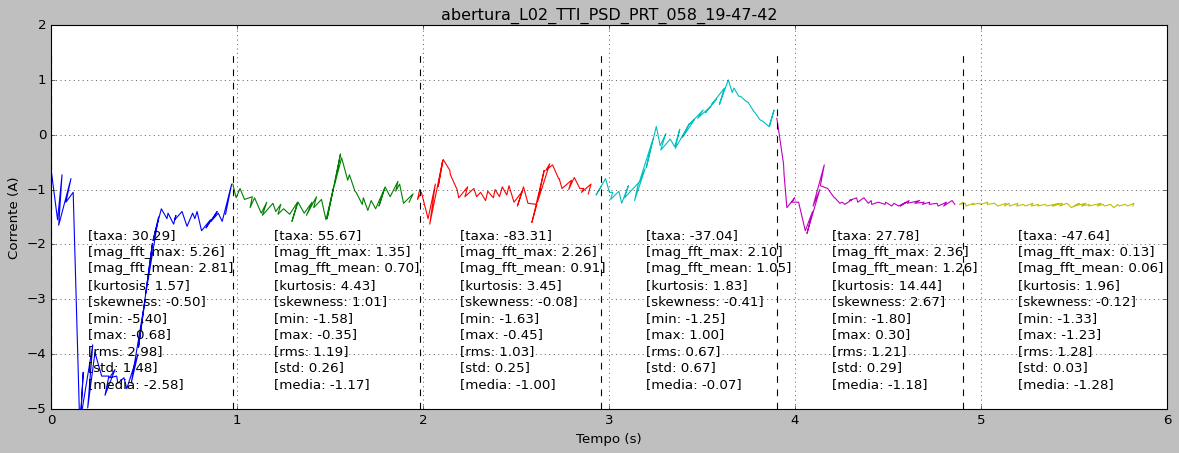

         tempo  corrente
10    0.032983     -0.27
2     0.009013     -0.72
14    0.044971     -0.72
27    0.084011     -1.65
28    0.087013     -1.95
...        ...       ...
1948  5.846982     -1.10
1960  5.882987     -1.05
1962  5.888985     -1.10
1974  5.924985     -1.03
1976  5.930985     -1.10

[284 rows x 2 columns]


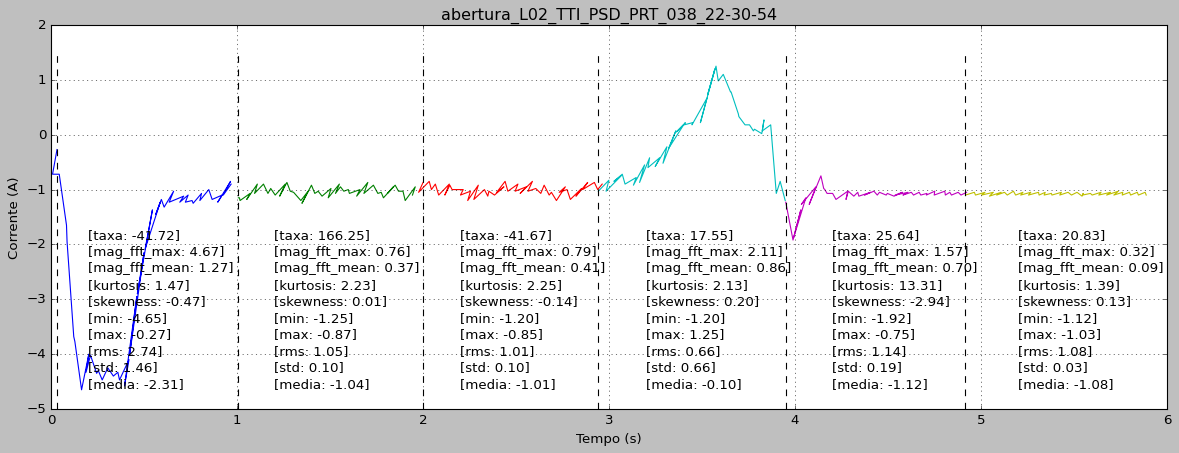

         tempo  corrente
0     0.003021     -0.13
12    0.039009     -0.78
18    0.056995     -0.58
25    0.077985     -1.72
26    0.080983     -1.80
...        ...       ...
1959  5.882008     -1.32
1965  5.899980     -1.13
1969  5.911997     -1.32
1976  5.932985     -1.18
1982  5.950997     -1.30

[306 rows x 2 columns]


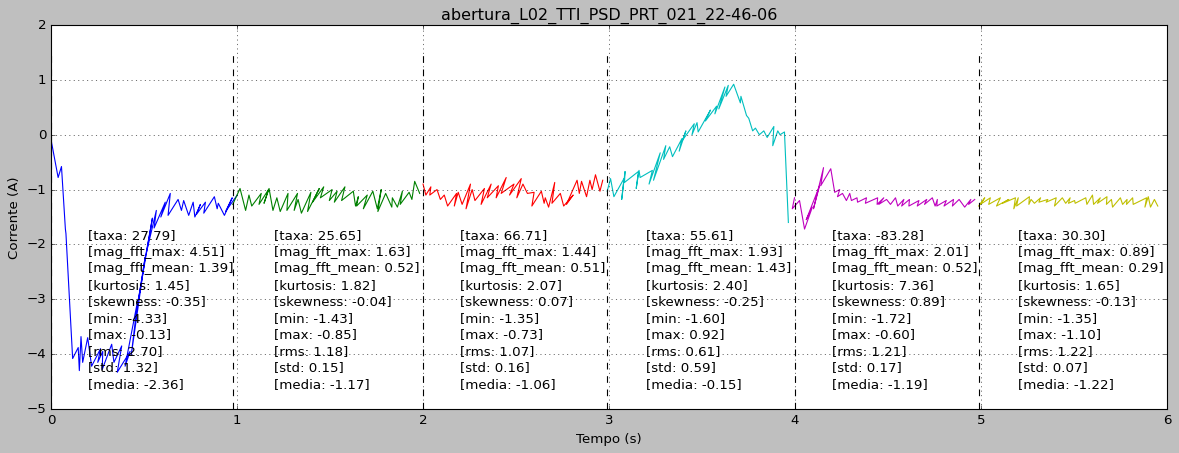

In [ ]:
'''
Codigo para gerar as figuras das curvas de corrente
'''

def reduce_time(df, window_ms):
    window_seconds = window_ms / 1000
    # Calculate the difference in time (assumed to be in seconds)
    time_diff = df['tempo'].diff().mean()
    # Average time difference between rows (sampling rate in seconds)
    # Calculate the number of rows (samples) per window based on the desired window duration in seconds
    samples_per_window = int(window_seconds / time_diff)
    # Initialize a list to store the reduced data
    reduced_data = []
    # Iterate over the DataFrame in steps of samples_per_window
    for i in range(0, len(df), samples_per_window):
    # Define the window slice
        window = df.iloc[i:i + samples_per_window]
        if len(window) == 0:
            continue
        # Get the max, min, and mean values of the 'current' column and their corresponding 'time'
        max_row = window.loc[window['corrente'].idxmax()]
        min_row = window.loc[window['corrente'].idxmin()]
        mean_current = window['corrente'].mean()
        mean_time = window['tempo'].mean()
        # Add the max, min, and mean rows to the reduced data
        reduced_data.append(max_row)
        #reduced_data.append(pd.Series({'tempo': mean_time, 'corrente': mean_current}))
        reduced_data.append(min_row)
    # Convert the reduced data into a DataFrame
    reduced_df = pd.DataFrame(reduced_data)
    return reduced_df

def reduce_windows(df, n_windows):
    # Calculate the window size based on the number of windows
    window_size = len(df) // n_windows
    # Initialize a list to store the reduced data
    reduced_data = []
    # Iterate over each window
    for i in range(n_windows):
        # Define the window slice
        window_start = i * window_size
        window_end = (i + 1) * window_size if (i + 1) * window_size < len(df) else len(df)
        # Get the window data
        window = df.iloc[window_start:window_end]
        # Get the max and min values of the 'current' column and their corresponding 'time'
        mean_current = window['corrente'].mean()
        mean_time = window['tempo'].mean()
        max_row = window.loc[window['corrente'].idxmax()]
        min_row = window.loc[window['corrente'].idxmin()]
        # Add the max and min rows to the reduced data
        reduced_data.append(max_row)
        #reduced_data.append(pd.Series({'tempo': mean_time, 'corrente': mean_current}))
        reduced_data.append(min_row)

    # Convert the reduced data into a DataFrame
    reduced_df = pd.DataFrame(reduced_data)
    return reduced_df

path_curvas = "curvas/"

# Parâmetros de segmentação
pasta = f"curvas/"
arquivos = os.listdir(pasta)
for arquivo in arquivos[:3]:
    if(arquivo[-4:] != ".csv"):
        continue

    path = f"{pasta}{arquivo}"

    curva = pd.read_csv(path, sep=';')
    curva.rename(columns={curva.columns[0]: "tempo"}, inplace=True)
    curva.rename(columns={curva.columns[1]: "corrente"}, inplace=True)
    # transforma o tempo de microssegundos para segundos
    curva['tempo'] = curva['tempo']/1000000
    #curva['corrente'] = (curva['corrente'] - 12.08)*2.5
    curva = reduce_time(curva, window_ms=42)
    print(curva)
    tamanho_janela = int(len(curva)/6)
    segmentos = psd.segmentar_sinal(curva, tamanho_janela)
    ft = psd.extrair_features_temporais(segmentos)
    ff = psd.extrair_features_frequenciais(segmentos)

    pp.plotar_curva(segmentos, ft, ff, title=f"{arquivo[:-4]}")
    #pp.plotar_fft(ff)

In [ ]:
'''
codigo para gerar o arquivo com as metricas das curvas e
categoriza-las em boas e ruins
'''

if(os.path.isfile("metricas_curva_psd_tti.csv")):
    os.remove("metricas_curva_psd_tti.csv")

'''
pega os arquivos de log das estacoes selecionadas
cada arquivo representa uma curva, sendo que para um mesmo ciclo os
arquivos estao separdos em curva de abertura e de fechamento
'''
arquivos = psd.pega_arquivos_log(cfg.estacoes_coleta, cfg.data_coleta, cfg.hora_coleta, cfg.path)
arquivos = os.listdir("curvas")
for i, arquivo in enumerate(arquivos):
    arquivos[i] = f"curvas/{arquivo}"

'''
para cada arquivo faz a analise da curva e adiciona uma linha
no arquivo de log para analise, com as metricas extraidas
'''
for arquivo in arquivos:
    psd.analise_curva(arquivo, "curvas_teste", debug = 0)


# importa df com os valores extraidos das curvas
#df = pd.read_csv("metricas_curva_psd.csv", sep=';')

'''
categoriza cada uma das linhas(curva) em boa (label:1)
ou ruim (label:0) baseado nos limites de cada variavel
configurados no arquivo de configuracao
'''
#df = psd.categoriza_curvas(df, cfg.parametros, cfg.partes, cfg.limites, debug=0)

#df.head()

'\ncategoriza cada uma das linhas(curva) em boa (label:1)\nou ruim (label:0) baseado nos limites de cada variavel\nconfigurados no arquivo de configuracao\n'

# Clustering

In [ ]:
def load_dataset(path, seleciona=["abertura", "fechamento"]):
    """ Carrega o dataset e retorna ele normalizado

    :param path: caminho do dataset
    :param seleciona: seleciona as curvas que serao carregadas
    :return: dataset carregado e paths das curvas
    """

    # carrega o dataset
    df = pd.read_csv(path, sep=";")
    # checa o shape do dataset
    row, col = df.shape
    print(f'Ha {row} linhas e {col} colunas no dataset completo')

    if seleciona != ["abertura", "fechamento"]:
        df = df[df['curva'].str.contains(seleciona[0])]
        row, col = df.shape
        print(f'Ha {row} linhas e {col} colunas no dataset de {seleciona[0]}')
        print(df['curva'])

    df_paths = df.iloc[:, 0]
    df.drop('curva', axis='columns', inplace=True)
    #features = df_scaled.iloc[:, 1:].values

    return df, df_paths

def normaliza_dataset(df, scaler=""):
    """ Normaliza o dataset
    :param df: dataset a ser normalizado
    :param scaler: instancia do scaler a ser usado
    :return: dataset normalizado e scaler usado
    """
    if scaler == "":
        scaler = StandardScaler()
    features = scaler.fit_transform(df)
    features = pd.DataFrame(features, columns=df.columns)

    return features, scaler

def pca_reduction(features, dimensions = 2, pca=""):
    """Usa PCA para reduzir as dimensionalidades do dataset

    :param features: dataset normalizado com as features
    :return: pca result, pca para plotar
    """
    indices = []
    if pca == "":
        pca = PCA(n_components=dimensions)
    features_pca = pca.fit_transform(features)
    print(f"Variacao explicada da principal componente: {pca.explained_variance_ratio_}")
    print(f"Variacia cumulativa explicada pelas {dimensions} principal componentes: {np.sum(pca.explained_variance_ratio_):.2f}")

    # resultados do pca.components_
    for i in range(1, dimensions+1):
        indices.append(f'PC_{i}')

    dataset_pca = pd.DataFrame(abs(pca.components_), columns=features.columns, index=indices)
    print('\n\n', dataset_pca)

    print("\n*************** Features mais importantes *************************")
    for i in range(1, dimensions+1):
        print(f"Como PC {i}:\n{(dataset_pca[dataset_pca > 0.25].iloc[i-1]).dropna()}")

    print("\n\n******************************************************************")

    return features_pca, pca


def kmean_hyper_param_tuning(data):
    """
    Hyper parameter tuning para selecionar o melhor de todos os parametros com base no silhouette_score.

    :param data: dados com dimensoes reduzidas apos o PCA
    :return: melhor numero de clusters para o modelo (usado para KMeans n_clusters)
    """
    # possiblidades de numero de clusters
    parameters = [2, 3, 4, 5, 10, 15]

    # instancia ParameterGrid, passando o numero de clusters como input
    parameter_grid = ParameterGrid({'n_clusters': parameters})

    best_score = -1
    kmeans_model = KMeans()     # instantiating KMeans model
    silhouette_scores = []

    # avaliacao baseada no silhoute_score
    for p in parameter_grid:
        kmeans_model.set_params(**p)    # set seta o hyper parameter atual
        kmeans_model.fit(data)          # fit model no dataset, isso vai achar os clusters baseado no parametro p

        ss = metrics.silhouette_score(data, kmeans_model.labels_)   # calcula silhouette_score
        silhouette_scores += [ss]       # guarda todos os scores

        print('Parametro:', p, 'Score', ss)

        # checa p que tem o melhor score
        if ss > best_score:
            best_score = ss
            best_grid = p

    # plota silhouette score
    plt.bar(range(len(silhouette_scores)), list(silhouette_scores), align='center', color='#722f59', width=0.5)
    plt.xticks(range(len(silhouette_scores)), list(parameters))
    plt.title('Silhouette Score', fontweight='bold')
    plt.xlabel('Numero de clusters')
    plt.show()

    return best_grid['n_clusters']


def remove_feature(df, feature_name, partes):
    """ Remove uma feature do dataset

    :param df: dataset com as features
    :param feature_name: nome da feature a ser removida
    :param partes: partes da curva a serem removidas a feature
    """
    for i in partes:
        df.drop(f'{feature_name}{i}', axis='columns', inplace=True)
    return df

def line_svm(ax, df_features_pca, df_labels):
    '''cria uma linha que separa os clusters do dataset
    :param ax: eixo para plotagem
    :param df_features_pca: features do dataset
    :param df_labels: K Means labels
    '''
    # Create a linear SVM classifier
    svm = SVC(kernel='linear')
    # Fit the SVM model to your data
    svm.fit(df_features_pca, df_labels)
    # Get the coefficients and intercept of the hyperplane
    w = svm.coef_[0]
    a = -w[0] / w[1]
    xx = np.linspace(np.min(df_features_pca[:, 0]), np.max(df_features_pca[:, 0]))
    yy = a * xx - (svm.intercept_[0]) / w[1]
    # Plot the separating line
    ax.plot(xx, yy, 'k-')
    return ax

def plot_pca_2d(pca_result, pca, label, centroids):
    """ Visualizacao dos resultados

    :param pca_result: dado com PCA aplicado
    :param label: K Means labels
    :param centroids_pca: PCA format K Means centroids
    """
    # ------------------ Matplotlib para plotar -----------------------
    #fig, ax = plt.figure()
    fig, ax = plt.subplots(1, 1, figsize=(12, 6))

    x = pca_result[:, 0]
    y = pca_result[:, 1]

    centroids_pca = pca.transform(centroids)

    ax.scatter(x, y, c=label, alpha=0.5, s=200)  # plota os clusters com cores diferentes
    ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], marker='X', s=200, linewidths=1.5,
                color='red', edgecolors="black", lw=1.5)

    ax = line_svm(ax, pca_result, label)

    plt.xlim([np.min(pca_result[:, 0]), np.max(pca_result[:, 0])])
    plt.ylim([np.min(pca_result[:, 1]), np.max(pca_result[:, 1])])
    #plt.ylim(-400, 800)

    ax.set_title('Clusters das curvas de corrente', fontsize=18)
    ax.set_xlabel('PCA 1', fontsize=16)
    ax.set_ylabel('PCA 2', fontsize=16)
    plt.show()


def plot_pca_3d(pca_result, pca, label, centroids):
    """ Visualizacao dos resultados

    :param df_features: features do dataset
    :param df_labels: K Means labels
    """

    x = pca_result[:, 0]
    y = pca_result[:, 1]
    z = pca_result[:, 2]

    centroids_pca = pca.transform(df_centroids)

    # cria o plot 3d
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=df_labels, marker='o')
    ax.scatter(centroids_pca[:, 0], centroids_pca[:, 1], centroids[:, 2], marker='X', s=200, linewidths=1.5,
            color='red', edgecolors="black", lw=1.5)
    #ax = line_svm(ax, pca_result, label)

    ax.set_title('Clusters das curvas de corrente')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    plt.show()


In [ ]:
print("[1] Carregando dataset\n")
path = "metricas_curva_psd.csv"
df_features, df_paths = load_dataset(path, seleciona=["abertura"])

df_features, df_paths = load_dataset(path, seleciona=["fechamento"])

df_features = remove_feature(df_features, "taxa", [1,2,3,4,5,6])

print(df_features.head())

[1] Carregando dataset

Ha 9504 linhas e 62 colunas no dataset completo
Ha 4752 linhas e 62 colunas no dataset de abertura
0       /mnt/mdl_data/PSD/TTI_via1/2024-09-05/10/abert...
1       /mnt/mdl_data/PSD/TTI_via1/2024-09-05/10/abert...
2       /mnt/mdl_data/PSD/TTI_via1/2024-09-05/10/abert...
4       /mnt/mdl_data/PSD/TTI_via1/2024-09-05/10/abert...
5       /mnt/mdl_data/PSD/TTI_via1/2024-09-05/10/abert...
                              ...                        
9490    /mnt/mdl_data/PSD/TTI_via1/2024-09-05/23/abert...
9496    /mnt/mdl_data/PSD/TTI_via1/2024-09-05/23/abert...
9497    /mnt/mdl_data/PSD/TTI_via1/2024-09-05/23/abert...
9498    /mnt/mdl_data/PSD/TTI_via1/2024-09-05/23/abert...
9501    /mnt/mdl_data/PSD/TTI_via1/2024-09-05/23/abert...
Name: curva, Length: 4752, dtype: object
Ha 9504 linhas e 62 colunas no dataset completo
Ha 4752 linhas e 62 colunas no dataset de fechamento
3       /mnt/mdl_data/PSD/TTI_via1/2024-09-05/10/fecha...
9       /mnt/mdl_data/PSD/TTI_via1/2024

[1] Carregando dataset

Ha 9504 linhas e 62 colunas no dataset completo
Ha 4752 linhas e 62 colunas no dataset de abertura
0       /mnt/mdl_data/PSD/TTI_via1/2024-09-05/10/abert...
1       /mnt/mdl_data/PSD/TTI_via1/2024-09-05/10/abert...
2       /mnt/mdl_data/PSD/TTI_via1/2024-09-05/10/abert...
4       /mnt/mdl_data/PSD/TTI_via1/2024-09-05/10/abert...
5       /mnt/mdl_data/PSD/TTI_via1/2024-09-05/10/abert...
                              ...                        
9490    /mnt/mdl_data/PSD/TTI_via1/2024-09-05/23/abert...
9496    /mnt/mdl_data/PSD/TTI_via1/2024-09-05/23/abert...
9497    /mnt/mdl_data/PSD/TTI_via1/2024-09-05/23/abert...
9498    /mnt/mdl_data/PSD/TTI_via1/2024-09-05/23/abert...
9501    /mnt/mdl_data/PSD/TTI_via1/2024-09-05/23/abert...
Name: curva, Length: 4752, dtype: object
   amostragem    media1      std1      rms1      max1      min1  skewness1  \
0    0.971471  0.490674  0.082242 -0.475058 -0.307591  0.055717  -0.124737   
1    0.337114  0.457662 -0.369938 -0.63174

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but PCA was fitted with feature names
  warnings.warn(


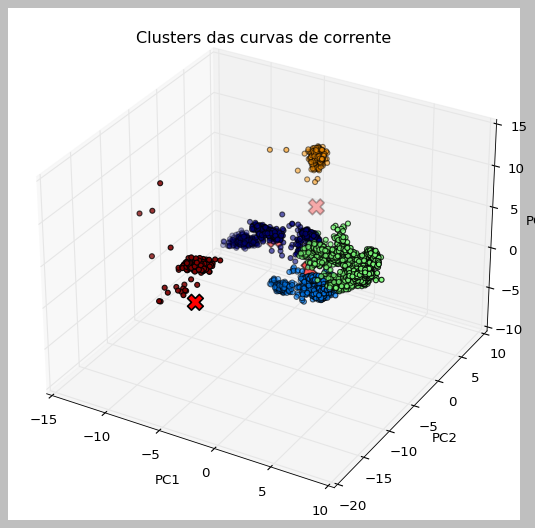

In [ ]:
print("[1] Carregando dataset\n")
path = "metricas_curva_psd.csv"
df_features, df_paths = load_dataset(path, seleciona=["abertura"])
df_features, scaler = normaliza_dataset(df_features)
df_features = remove_feature(df_features, "taxa", [1,2,3,4,5,6])

print(df_features.head())


print("\n\n[2] Reduzindo D via PCA\n")
#df_features_pca_2d, pca_2d = pca_reduction(df_features)
df_features_pca_3d, pca_3d = pca_reduction(df_features, 3)

print("\n\n[3] HyperTuning o parametro para o KMeans\n")
optimum_num_clusters = 5
#optimum_num_clusters = kmean_hyper_param_tuning(df_features)
print("- Melhor numero de clusters =", optimum_num_clusters)

# fitting KMeans
kmeans = KMeans(n_clusters=optimum_num_clusters, n_init=10, random_state=42)
kmeans.fit(df_features)
df_labels = kmeans.labels_
df_centroids = kmeans.cluster_centers_

# Create a DataFrame to associate paths with clusters
result_df = pd.DataFrame({'Path': df_paths, 'Cluster': df_labels})
print(result_df.head())


print("\n\n[4] Visualizando os dados")
#plot_pca_2d(df_features_pca_2d, pca_2d, df_labels, df_centroids)
plot_pca_3d(df_features_pca_3d, pca_3d, df_labels, df_centroids)

In [ ]:
print("[1] Carregando dataset\n")
path = "curvas_teste.csv"
df_features, df_paths = load_dataset(path, seleciona=["abertura"])
df_normalizado, scaler = normaliza_dataset(df_features, scaler=scaler)
df_features = remove_feature(df_features, "taxa", [1,2,3,4,5,6])

# aplica a mesma transformacao PCA nas features
feature_nova_pca, pca = pca_reduction(df_normalizado, dimensions =3, pca=pca_3d)

# prediz o cluster da nova curva baseada no modelo
df_labels = kmeans.predict(df_features)
# Create a DataFrame to associate paths with clusters
result_novas = pd.DataFrame({'Path': df_paths, 'Cluster': df_labels})
print(result_novas.head())

[1] Carregando dataset

Ha 18 linhas e 62 colunas no dataset completo
Ha 18 linhas e 62 colunas no dataset de abertura
0     curvas/abertura_L02_TTI_PSD_PRT_058_19-47-42.csv
1     curvas/abertura_L02_TTI_PSD_PRT_038_22-30-54.csv
2     curvas/abertura_L02_TTI_PSD_PRT_021_22-46-06.csv
3     curvas/abertura_L02_TTI_PSD_PRT_044_22-46-06.csv
4     curvas/abertura_L02_TTI_PSD_PRT_043_22-46-06.csv
5     curvas/abertura_L02_TTI_PSD_PRT_023_22-35-25.csv
6     curvas/abertura_L02_TTI_PSD_PRT_017_22-41-37.csv
7     curvas/abertura_L02_TTI_PSD_PRT_053_22-40-48.csv
8     curvas/abertura_L02_TTI_PSD_PRT_013_22-53-40.csv
9     curvas/abertura_L02_TTI_PSD_PRT_067_19-47-42.csv
10    curvas/abertura_L02_TTI_PSD_PRT_025_22-46-54.csv
11    curvas/abertura_L02_TTI_PSD_PRT_014_22-53-40.csv
12    curvas/abertura_L02_TTI_PSD_PRT_012_22-46-06.csv
13    curvas/abertura_L02_TTI_PSD_PRT_061_22-46-06.csv
14    curvas/abertura_L02_TTI_PSD_PRT_065_19-43-07.csv
15    curvas/abertura_L02_TTI_PSD_PRT_054_22-35-25.csv
1

In [ ]:
result_df.to_csv('result_df.csv', sep=';')
result_novas.to_csv('result_novas.csv', sep=';')